In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import warnings 
warnings.filterwarnings('ignore')

In [2]:
le = LabelEncoder()
scaler = StandardScaler()

In [3]:
path = "C:/Users/user/Downloads/WaterMiningTZ"
data = pd.read_csv(path +'/TrainValues.csv') 
test = pd.read_csv(path +'/TestValues.csv')
label = pd.read_csv(path +'/Train_labels.csv') 

In [4]:
train = data.merge(label ,on ="id", how = "inner")

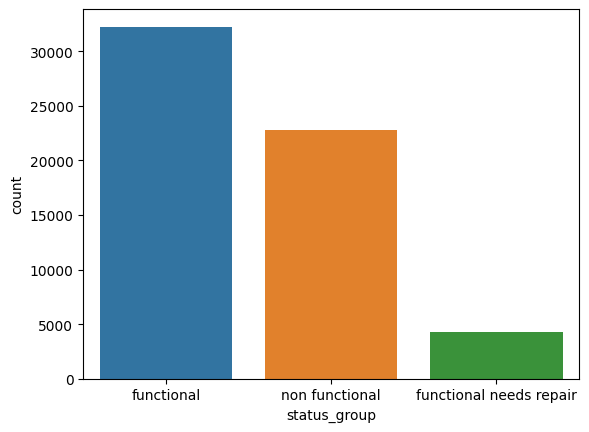

In [5]:
sns.countplot(x = "status_group", data = train)
plt.show()

In [6]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [7]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [8]:
for df in [train, test]:
     df["construction_year"] = pd.to_datetime(df["construction_year"])


train["length_active"] = 2023 - train["construction_year"].dt.year
test['length_active'] = 2023 - test["construction_year"].dt.year

In [9]:
columns_to_drop = ['date_recorded', 'longitude', 'latitude', 
                   'wpt_name', 'num_private','region_code', 'district_code',
                   'construction_year',"public_meeting","permit"]

for column in columns_to_drop:
    if column in train.columns:
        train.drop(columns=column, inplace=True)
    if column in test.columns:
        test.drop(columns=column, inplace=True)

In [10]:
num_col_train = train.select_dtypes(include=[np.number])
num_col_test = test.select_dtypes(include=[np.number])
train[num_col_train.columns] = train[num_col_train.columns].fillna(0)
test[num_col_test.columns] = test[num_col_test.columns].fillna(0)

cat_col_train = train.select_dtypes(exclude=[np.number])
cat_col_test = test.select_dtypes(exclude=[np.number])
train[cat_col_train.columns] = train[cat_col_train.columns].fillna("None")
test[cat_col_test.columns] = test[cat_col_test.columns].fillna("None")

In [11]:
print(train["status_group"].unique())

['functional' 'non functional' 'functional needs repair']


In [12]:
functional = train[train["status_group"] =="functional"]
non_functional = train[train["status_group"] =="non functional"]
needs_repair = train[train["status_group"] == "functional needs repair"]

In [13]:
functional_sample = functional.sample(n = 4317)
non_functional_sample = non_functional.sample(n = 4317)

In [14]:
df = pd.concat([functional_sample,non_functional_sample,needs_repair],axis=0)

In [15]:
df.shape

(12951, 32)

In [16]:
df.head()

,id,amount_tsh,funder,gps_height,installer,basin,subvillage,region,lga,ward,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,length_active
43482,31720,500.0,Adb,1776,DWE,Rufiji,Kichiwa B,Iringa,Njombe,Igongolo,...,good,enough,enough,hand dtw,borehole,groundwater,hand pump,hand pump,functional,53
17154,35956,0.0,Government Of Tanzania,0,DWE,Lake Victoria,Kibogoizi,Kagera,Karagwe,Ihembe,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,53
22565,47981,0.0,Government Of Tanzania,1212,Government,Lake Victoria,Kwisayenge,Mara,Musoma Rural,Nyambono,...,salty,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,53
11291,35419,50.0,China Government,128,Ch,Wami / Ruvu,Chalinze Mzee A,Pwani,Bagamoyo,Chalinze,...,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,53
59399,26348,0.0,World Bank,191,World,Wami / Ruvu,Kikatanyemba,Morogoro,Morogoro Rural,Ngerengere,...,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,53


In [17]:
df["status_group"] = le.fit_transform(df["status_group"])

In [18]:
X = df.drop(["id","status_group"],axis=1)
y = df["status_group"]

In [19]:
def process_data(data):
    processed_data = data.copy()

    cat_cols = processed_data.select_dtypes(include=["object"])

    for col in cat_cols:
        processed_data[col] = le.fit_transform(processed_data[col])

    num_cols = processed_data.select_dtypes(include=[np.number])
    processed_data[num_cols.columns] = scaler.fit_transform(processed_data[num_cols.columns])

    return pd.DataFrame(processed_data, columns = processed_data.columns)

In [20]:
processed_train = process_data(X)

In [21]:
processed_test = process_data(test)

In [22]:
X_train,X_test,y_train,y_test = train_test_split(processed_train,y,
                                                 test_size=0.2,random_state=42)

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred,average='micro')
print(f1)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest,f_classif

In [ ]:
X_train.shape

(47520, 39)

In [ ]:
'''
def calculate_accuracy(y_test,y_pred):
     return accuracy_score(y_test,y_pred)

models = {
     "XGBClassifier" : XGBClassifier(random_state=42),
     "GradientBoosting": GradientBoostingClassifier(random_state=42),
     "LogisticRegression" : LogisticRegression(),
     "DecisionTree" : DecisionTreeClassifier(random_state=42),
     "RandomForest" : RandomForestClassifier(random_state=42)
} 
  
accuracy_values = []

for name, model in models.items():
     model.fit(X_train,y_train)
     y_pred = model.predict(X_test)
     accuracy_values.append(accuracy_score(y_test,y_pred))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(x = list(models.keys()),y = accuracy_values,palette = "viridis")
plt.title("Accuracy of Models")
plt.ylabel("ACCURACY")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()
'''

: 

In [ ]:
xg = XGBClassifier()
rf = RandomForestClassifier()

models = [xg,rf]
model_names = ["XGBoost", "Random Forest"]

accuracy = []

for model,model_name in zip(models,model_names):
     model.fit(X_train,y_train)
     preds = model.predict(X_test)
     acc = accuracy_score(y_test,preds)
     accuracy.append(acc)
     print(f"Accuracy of {model_name} : {acc:.4f}")

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:date_recorded: datetime64[ns]

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
xg = XGBClassifier()
rf = RandomForestClassifier()

models = [("XGBoost",xg),("Random Forest",rf)]

voting_classifier = VotingClassifier(estimators=models,voting="soft")
voting_classifier.fit(X_train_selected,y_train)

y_pred = voting_classifier.predict(X_test_selected)

ensemble_probabilities = voting_classifier.predict_proba(X_test_selected)[:, 1] 
ensemble_accuracy = accuracy_score(y_test, ensemble_probabilities)
print(f"Ensemble accuracy: {ensemble_accuracy:.4f}")

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [ ]:
class_probabilities = .predict_proba(X_test_selected)


print(f"ROC AUC: {roc_auc:.4f}").predict_proba(X_test_selected)

roc_auc = roc_auc_score(y_test, class_probabilities[:,1]) 

print(f"Accuracy: {roc_auc:.4f}")

In [ ]:
test.status_group = y_pred_orig

In [ ]:
mining_submission = pd.DataFrame({"id":test["id"],
                                   "status_group":y_pred})

ValueError: array length 5940 does not match index length 14850